In [91]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import csv
from collections import Counter
from math import sqrt
import os

# Visualization libraries
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import  RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import matplotlib.pyplot as plt

# Progress bar for loops
from tqdm.notebook import tqdm

if not os.path.exists("images"):
    os.mkdir("images")

In [9]:
speech = pd.read_csv('outliercorrected_pd_speech_features.csv',header=[0,1],index_col=0)
display(speech)

# make a list of columns that contain all features, that are not patient id, class and gender
column_list = list(speech.columns)
feature_columns  = column_list.copy()
feature_columns.remove(('Info','class'))
feature_columns.remove(('Info','gender'))
display(feature_columns)

Info Baseline Features                                                   \
    gender               PPE       DFA      RPDE   numPulses numPeriodsPulses   
ID                                                                              
0      1.0          0.823387  0.696370  0.567250  235.333333       234.333333   
1      0.0          0.422263  0.793993  0.592453  213.333333       211.000000   
2      1.0          0.801973  0.619967  0.520563  319.333333       318.333333   
3      0.0          0.828707  0.626097  0.537183  493.000000       492.000000   
4      0.0          0.831287  0.779397  0.726717  362.666667       361.666667   
..     ...               ...       ...       ...         ...              ...   
247    0.0          0.751703  0.651830  0.586847  326.000000       324.666667   
248    1.0          0.611750  0.688327  0.452343  356.666667       355.333333   
249    1.0          0.819857  0.788800  0.373520  339.666667       338.666667   
250    0.0          0.600530  0.569010  0.411987  402.333333       401.000000   
251    0.0          0.844917  0.745653  0.476707  353.666667       352.666667   

                                                                   ...  \
    meanPeriodPulses stdDevPeriodPulses locPctJitter locAbsJitter  ...   
ID                                                                 ...   
0           0.008220           0.000073     0.001963     0.000016  ...   
1           0.008884           0.001849     0.005790     0.000050  ...   
2           0.006041           0.000104     0.002217     0.000013  ...   
3           0.003913           0.000042     0.000757     0.000003  ...   
4           0.005622           0.002023     0.003593     0.000021  ...   
..               ...                ...          ...          ...  ...   
247         0.005911           0.000251     0.003193     0.000019  ...   
248         0.005410           0.000964     0.002467     0.000014  ...   
249         0.005684           0.000042     0.000800     0.000005  ...   
250         0.004775           0.000103     0.000983     0.000005  ...   
251         0.005475           0.000065     0.000820     0.000005  ...   

                TQWT Features                            \
    tqwt_kurtosisValue_dec_28 tqwt_kurtosisValue_dec_29   
ID                                                        
0                    1.561733                  2.862000   
1                    4.918567                  4.827133   
2                   41.129400                 31.201933   
3                    1.677633                  1.908400   
4                    4.104600                  4.285233   
..                        ...                       ...   
247                 19.298667                 15.072200   
248                  4.448533                  3.180933   
249                 90.482767                 65.641367   
250                  2.674667                  2.714200   
251                 44.571367                 26.370167   

                                                         \
    tqwt_kurtosisValue_dec_30 tqwt_kurtosisValue_dec_31   
ID                                                        
0                   12.293333                  9.717500   
1                    6.117633                  8.599667   
2                   14.584467                  5.446800   
3                    2.842167                  3.493867   
4                    2.953200                  2.799933   
..                        ...                       ...   
247                 13.479700                 14.877933   
248                  2.880233                  2.805067   
249                 29.098533                  8.966500   
250                  2.706000                  2.637700   
251                 14.782567                  4.455833   

                                                         \
    tqwt_kurtosisValue_dec_32 tqwt_kurtosisValue_dec_33   
ID                                                        
0  

[('Baseline Features', 'PPE'),
 ('Baseline Features', 'DFA'),
 ('Baseline Features', 'RPDE'),
 ('Baseline Features', 'numPulses'),
 ('Baseline Features', 'numPeriodsPulses'),
 ('Baseline Features', 'meanPeriodPulses'),
 ('Baseline Features', 'stdDevPeriodPulses'),
 ('Baseline Features', 'locPctJitter'),
 ('Baseline Features', 'locAbsJitter'),
 ('Baseline Features', 'rapJitter'),
 ('Baseline Features', 'ppq5Jitter'),
 ('Baseline Features', 'ddpJitter'),
 ('Baseline Features', 'locShimmer'),
 ('Baseline Features', 'locDbShimmer'),
 ('Baseline Features', 'apq3Shimmer'),
 ('Baseline Features', 'apq5Shimmer'),
 ('Baseline Features', 'apq11Shimmer'),
 ('Baseline Features', 'ddaShimmer'),
 ('Baseline Features', 'meanAutoCorrHarmonicity'),
 ('Baseline Features', 'meanNoiseToHarmHarmonicity'),
 ('Baseline Features', 'meanHarmToNoiseHarmonicity'),
 ('Intensity Parameters', 'minIntensity'),
 ('Intensity Parameters', 'maxIntensity'),
 ('Intensity Parameters', 'meanIntensity'),
 ('Formant Frequenci

In [88]:
def create_train_validation_test_split(df, target_column, test_size=0.2, validation_size=0.2, random_state=42):
    """
    Creates train, validation, and test sets.
    
    Parameters:
    df (pandas.DataFrame): The full dataset
    target_column (str): Name of the target variable column
    test_size (float): Proportion of the dataset to include in the test split
    validation_size (float): Proportion of the training data to include in the validation split
    random_state (int): Controls the shuffling applied to the data before applying the split
    
    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test
    """
    
    # Separate features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # First, split the data into training+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Then, split the training+validation set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=validation_size, random_state=random_state)
    
    # print(f"Training set shape: {X_train.shape}")
    # print(f"Validation set shape: {X_val.shape}")
    # print(f"Test set shape: {X_test.shape}")
    
    return X_train, X_val, X_train_val, X_test, y_train, y_val, y_train_val, y_test

def assign_dataset(index):
    if index in X_train.index:
        return 'train'
    elif index in X_val.index:
        return 'val'
    elif index in X_test.index:
        return 'test'
    else:
        return 'unknown'

In [89]:
def jackknife_feature_selection(X, y, n_features_to_select=10, n_estimators=100):
    # Convert multi-indexed DataFrame to numpy array
    X_train = X.values
    y_train = y.values if isinstance(y, pd.Series) else y
    
    feature_counts = Counter()
    
    # Jackknife procedure
    for i in range(X_train.shape[0]):
        # Remove one sample
        X_train_jackknife = np.delete(X_train, i, axis=0)
        y_train_jackknife = np.delete(y_train, i)
        
        # Rank features
        selector = SelectKBest(f_classif, k=n_features_to_select)
        selector.fit(X_train_jackknife, y_train_jackknife)
        
        # Get selected feature indices
        selected_features = selector.get_support(indices=True)
        
        # Update feature counts
        feature_counts.update(selected_features)
    
    # Get top features
    top_features = [feature for feature, count in feature_counts.most_common(n_features_to_select)]
    
    # Map feature indices back to column names
    feature_names = X.columns.tolist()
    selected_feature_names = [feature_names[i] for i in top_features]
    
    return selected_feature_names

def evaluate_feature_subset(X_train, X_test, y_train, y_test, feature_subset, n_estimators=100):
    # Select features from multi-indexed DataFrame
    X_subset = X_train[feature_subset]
    X_test_subset = X_test[feature_subset]
    
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rf.fit(X_subset, y_train)
    
    accuracy = rf.score(X_test_subset, y_test)
    return accuracy

def feature_selection_and_evaluation(X_train, X_val, y_train, y_val, n_features_to_select, n_estimators):
    # Perform jackknife feature selection
    selected_features = jackknife_feature_selection(X_train, y_train, n_features_to_select=n_features_to_select, n_estimators=n_estimators)
    print("Selected features:", selected_features)

    # Evaluate the selected feature subset
    accuracy_selected = evaluate_feature_subset(X_train, X_val, y_train, y_val, selected_features, n_estimators=n_estimators)
    print(f"Accuracy with selected features: {accuracy_selected:.4f}")

    # Compare with using all features
    accuracy_all = evaluate_feature_subset(X_train, X_val, y_train, y_val, X_train.columns, n_estimators=n_estimators)
    print(f"Accuracy with all features: {accuracy_all:.4f}")

    # Create a summary DataFrame
    result_df = pd.DataFrame({
        'Number of Estimators': n_estimators,
        'Number of Selected Features': n_features_to_select,
        'Accuracy with Selected Features': accuracy_selected,
        'Accuracy with All Features': accuracy_all,
        'Selected Features': [selected_features]
    })

    return result_df

  0%|          | 0/100 [00:00<?, ?it/s]

1
Selected features: [('MFCC ', 'std_delta_log_energy'), ('MFCC ', 'std_6th_delta'), ('MFCC ', 'std_7th_delta'), ('MFCC ', 'std_8th_delta'), ('MFCC ', 'std_9th_delta'), ('MFCC ', 'std_delta_delta_log_energy'), ('MFCC ', 'std_6th_delta_delta'), ('MFCC ', 'std_7th_delta_delta'), ('MFCC ', 'std_8th_delta_delta'), ('MFCC ', 'std_9th_delta_delta'), ('MFCC ', 'std_11th_delta_delta'), ('TQWT Features', 'tqwt_entropy_shannon_dec_12'), ('TQWT Features', 'tqwt_entropy_log_dec_12'), ('TQWT Features', 'tqwt_TKEO_mean_dec_12'), ('TQWT Features', 'tqwt_TKEO_std_dec_12'), ('TQWT Features', 'tqwt_stdValue_dec_11'), ('TQWT Features', 'tqwt_stdValue_dec_12'), ('TQWT Features', 'tqwt_minValue_dec_12'), ('TQWT Features', 'tqwt_maxValue_dec_11'), ('TQWT Features', 'tqwt_maxValue_dec_12'), ('TQWT Features', 'tqwt_kurtosisValue_dec_26'), ('MFCC ', 'std_10th_delta_delta'), ('TQWT Features', 'tqwt_entropy_shannon_dec_11'), ('MFCC ', 'mean_MFCC_2nd_coef'), ('TQWT Features', 'tqwt_minValue_dec_11'), ('MFCC ', 's

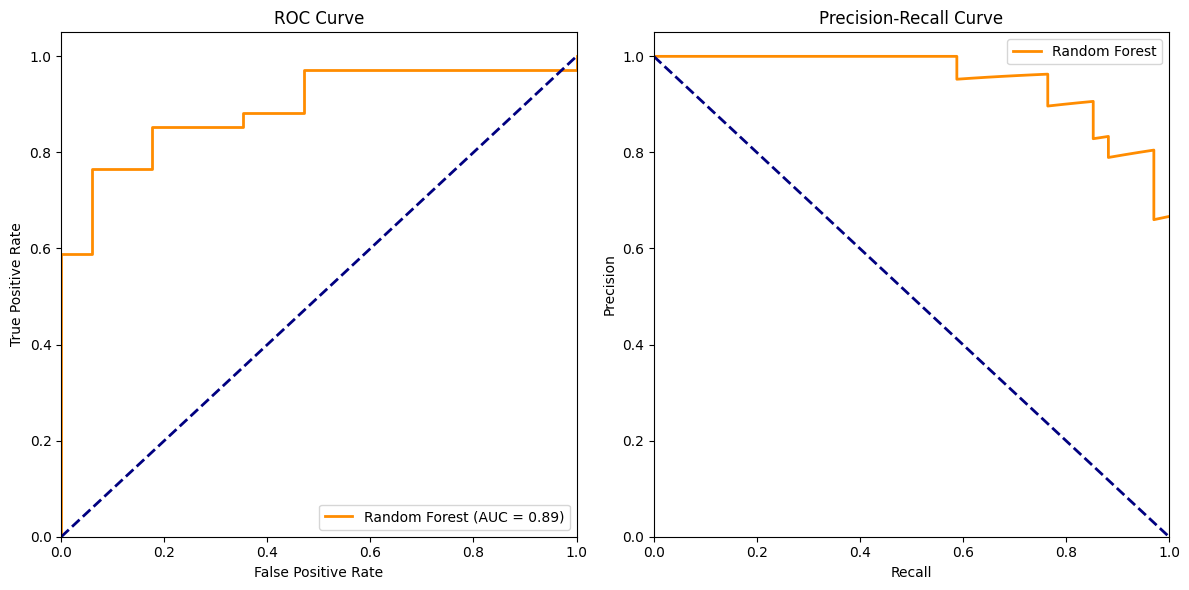

  0%|          | 0/100 [00:00<?, ?it/s]

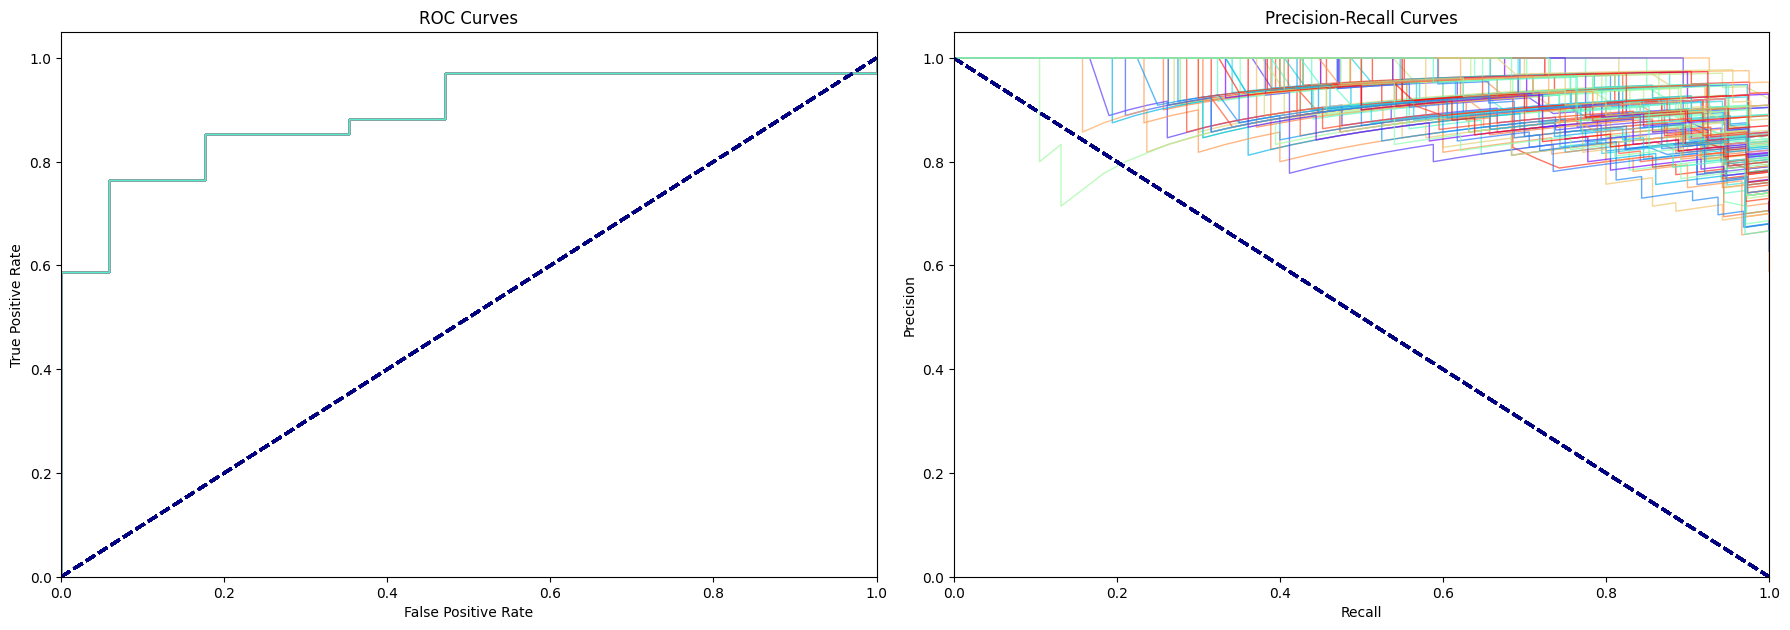

In [92]:
seed_list = range(1,101)
results_df = pd.DataFrame()
for random_state in tqdm(seed_list):
    print(random_state)
    X_train, X_val, X_train_val, X_test, y_train, y_val, y_train_val, y_test = create_train_validation_test_split(speech, ('Info','class'),random_state=random_state)
    speech_temp = speech.copy()
    speech_temp[('Info', 'dataset')] = speech_temp.index.map(assign_dataset)
    
    # Initialize the StandardScaler to scale and normalize the feature columns
    scaler = StandardScaler()
    # Scale the numerical feature columns of the DataFrame
    # 'feature_columns' is assumed to be a list of column names representing numerical features
    scaled_data = scaler.fit_transform(speech_temp[feature_columns])
    # Convert the scaled data back into a DataFrame with the same column names for easier reference
    scaled_speech = pd.DataFrame(scaled_data, columns=feature_columns)
    scaled_speech.index.name = 'ID'
    # Concatenate the unscaled categorical columns ('class', 'gender') with the scaled numerical columns
    # This ensures we keep the categorical data unchanged while normalizing the numerical data
    scaled_speech = pd.concat([speech_temp[[('Info', 'class'), ('Info', 'gender'),('Info', 'dataset')]], scaled_speech], axis=1)

    # Initialize Normalizer
    normalizer = Normalizer()
    # normalize the numerical feature columns of the DataFrame
    scaled_data = normalizer.fit_transform(speech_temp[feature_columns])
    # Convert the scaled data back into a DataFrame with the same column names for easier reference
    norm_speech = pd.DataFrame(scaled_data, columns=feature_columns)
    norm_speech.index.name = 'ID'
    # Concatenate the unscaled categorical columns ('class', 'gender') with the scaled numerical columns
    # This ensures we keep the categorical data unchanged while normalizing the numerical data
    norm_speech = pd.concat([speech_temp[[('Info', 'class'), ('Info', 'gender'),('Info', 'dataset')]], norm_speech], axis=1)

    speech_temp['dataset_class'] = (
        speech_temp[('Info', 'dataset')] + '_' + 
        speech_temp[('Info', 'class')].astype(str))

    # pca = PCA(n_components=3)
    # pca_result = pca.fit_transform(scaled_data)
    # percantage_explained = pca.explained_variance_ratio_
    # pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

    # fig = px.scatter(
        # pca_df, x='PC1', y='PC2', 
        # color=speech_temp['dataset_class'],  
        # symbol = speech_temp['dataset_class'],
        # title="",
        # labels={
            # 'PC1': f'PC1 ({percantage_explained[0]*100:.2f}%)',
            # 'PC2': f'PC2 ({percantage_explained[1]*100:.2f}%)'
        # },
    # )
    # fig.show()
    
    result_df = feature_selection_and_evaluation(X_train, X_val, y_train, y_val, int(sqrt(len(feature_columns))), 1000)
    result_df['random state'] = random_state
    results_df = pd.concat([results_df, result_df], axis=0)


feature_counts = Counter()
for feature in results_df['Selected Features'].values:
    feature_counts.update(feature)
top_features = [feature for feature, count in feature_counts.most_common(int(sqrt(len(feature_columns))))]

ROC AUC Score: 0.8927335640138407


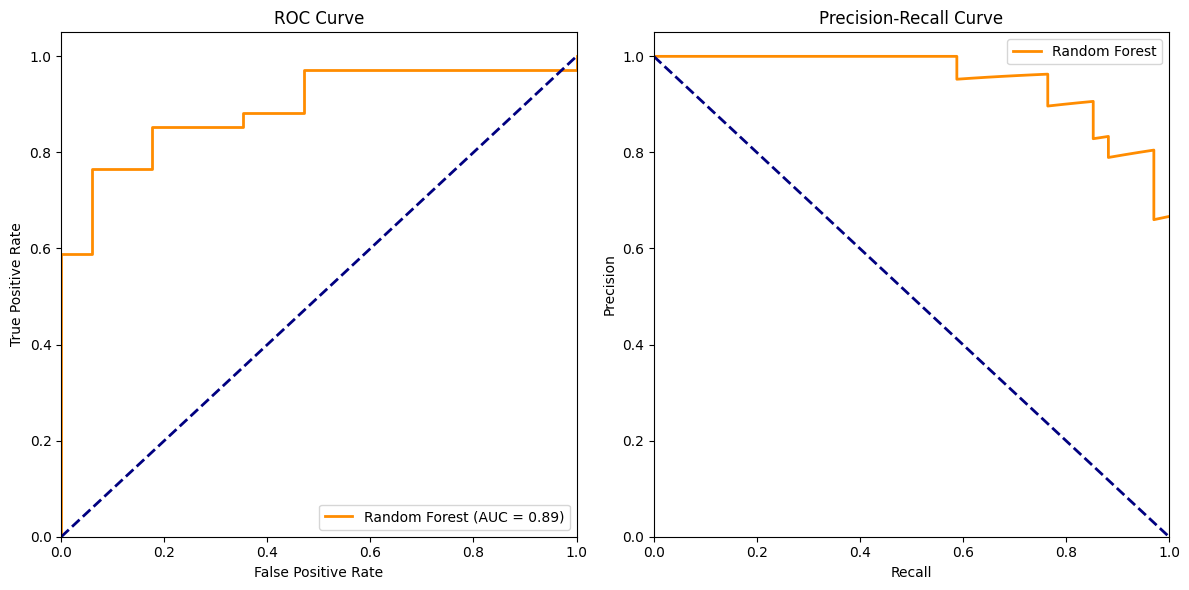

  0%|          | 0/100 [00:00<?, ?it/s]

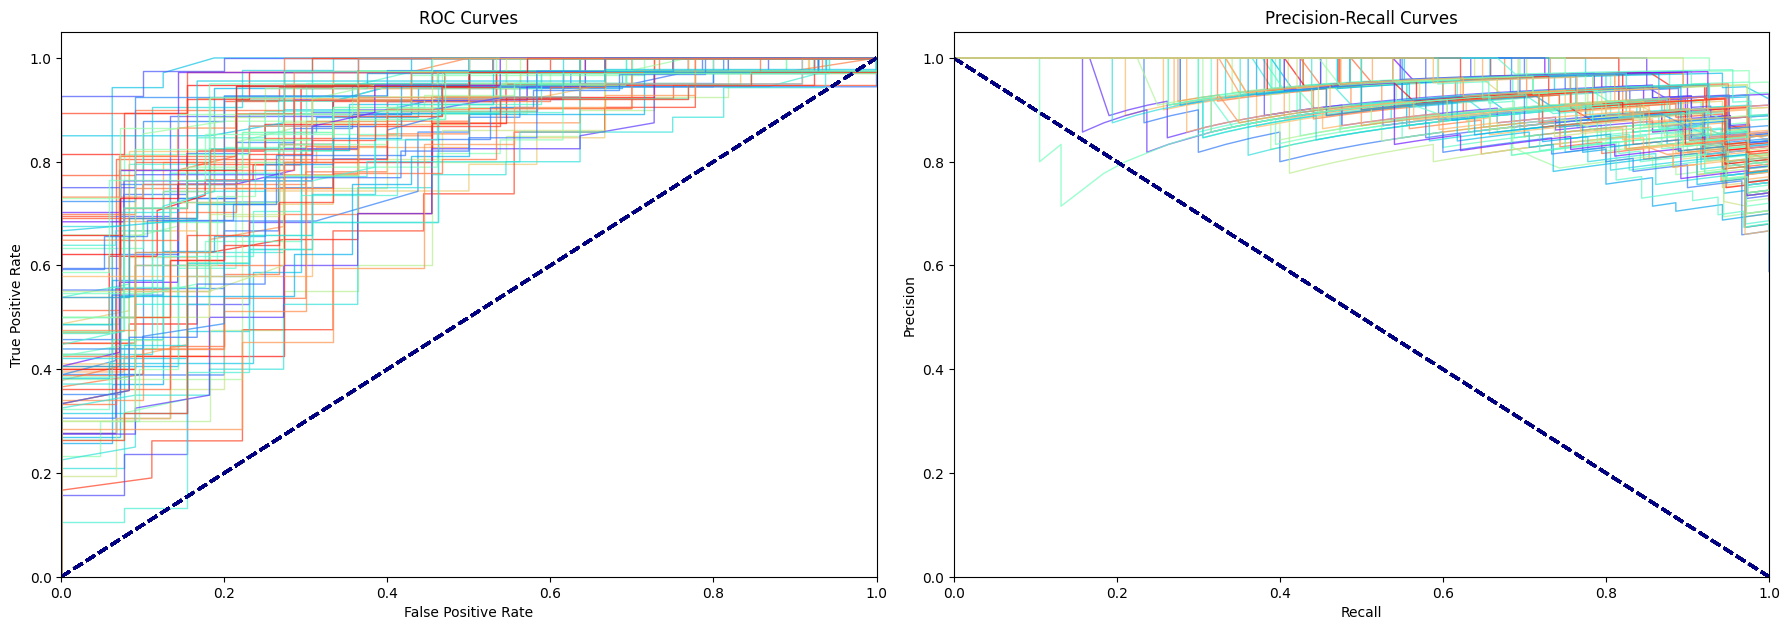

  0%|          | 0/100 [00:00<?, ?it/s]

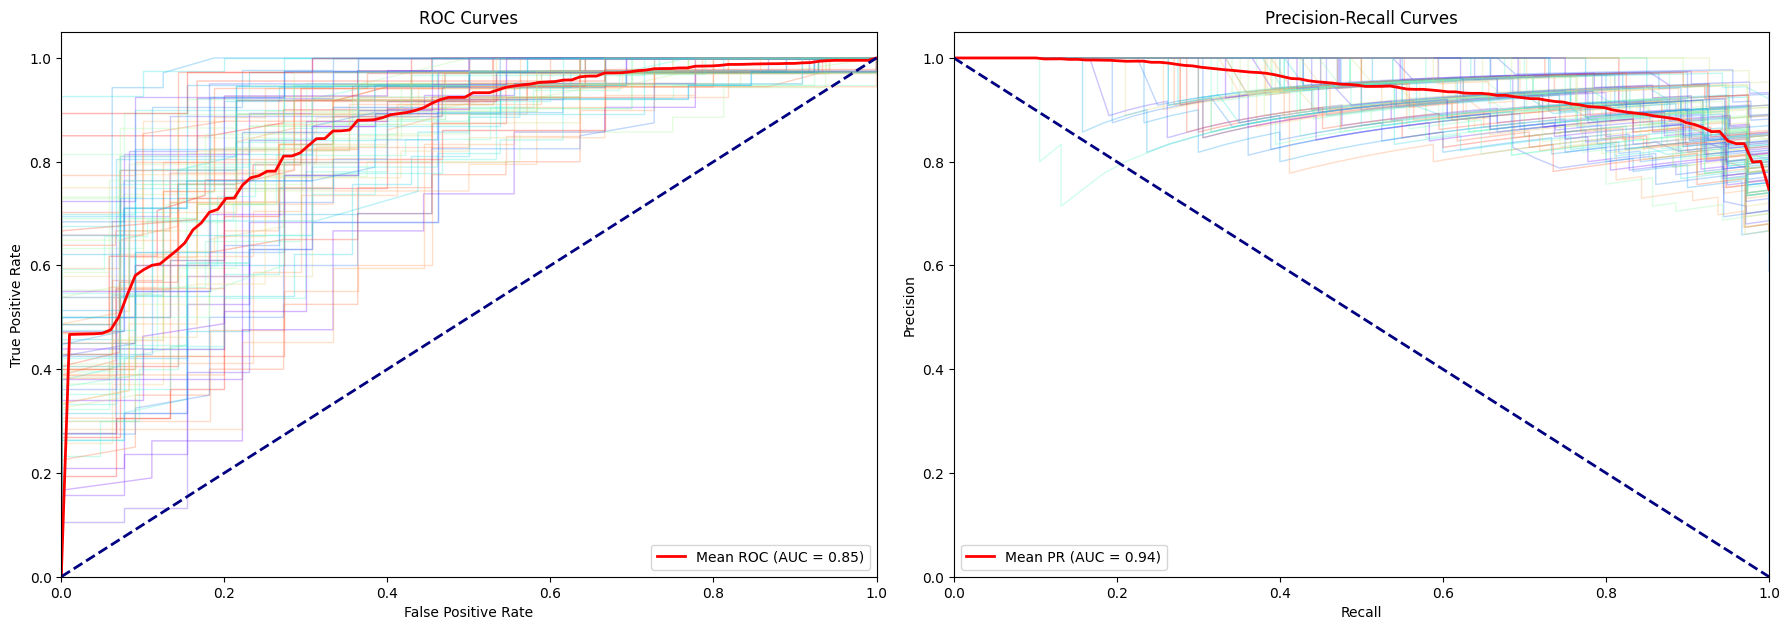

In [121]:
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state, n_jobs=-1)
# Get probability predictions
rf.fit(X_train_val[top_features],y_train_val)
y_pred_proba = rf.predict_proba(X_test[top_features])

# Calculate ROC AUC score
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"ROC AUC Score: {auc_roc}")

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])

# Plot ROC curve
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(122)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Random Forest')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

# Optionally, plot curves for multiple random states
plt.figure(figsize=(18, 12))
for random_state in tqdm(seed_list):
    X_train, X_val, X_train_val, X_test, y_train, y_val, y_train_val, y_test = create_train_validation_test_split(speech, ('Info','class'),random_state=random_state)
    rf = RandomForestClassifier(n_estimators=1000, random_state=random_state, n_jobs=-1)
    rf.fit(X_train_val[top_features], y_train_val)
    y_pred_proba = rf.predict_proba(X_test[top_features])
    
    auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    
    plt.subplot(221)
    plt.plot(fpr, tpr, color=plt.cm.rainbow(np.random.rand()), lw=1, alpha=0.7, label=f'Random State {random_state}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')

    plt.subplot(222)
    plt.plot(recall, precision, color=plt.cm.rainbow(np.random.rand()), lw=1, alpha=0.7, label=f'Random State {random_state}')
    plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')

plt.tight_layout()
plt.show()
import numpy as np
from sklearn.metrics import auc
from numpy import interp

plt.figure(figsize=(18, 12))

# Lists to store the curves for each random state
tprs = []
precisions = []
mean_fpr = np.linspace(0, 1, 100)

for random_state in tqdm(seed_list):
    X_train, X_val, X_train_val, X_test, y_train, y_val, y_train_val, y_test = create_train_validation_test_split(speech, ('Info','class'), random_state=random_state)
    rf = RandomForestClassifier(n_estimators=1000, random_state=random_state, n_jobs=-1)
    rf.fit(X_train_val[top_features], y_train_val)
    y_pred_proba = rf.predict_proba(X_test[top_features])
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    precisions.append(interp(mean_fpr, recall[::-1], precision[::-1])[::-1])
    
    plt.subplot(221)
    plt.plot(fpr, tpr, color=plt.cm.rainbow(np.random.rand()), lw=1, alpha=0.3)
    
    plt.subplot(222)
    plt.plot(recall, precision, color=plt.cm.rainbow(np.random.rand()), lw=1, alpha=0.3)

# Calculate and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.subplot(221)
plt.plot(mean_fpr, mean_tpr, color='red', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

# Calculate and plot mean Precision-Recall curve
mean_precision = np.mean(precisions, axis=0)
mean_recall = mean_fpr
mean_auc_pr = auc(mean_recall, mean_precision)

plt.subplot(222)
plt.plot(mean_recall,mean_precision[::-1], color='red', lw=2, label=f'Mean PR (AUC = {mean_auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


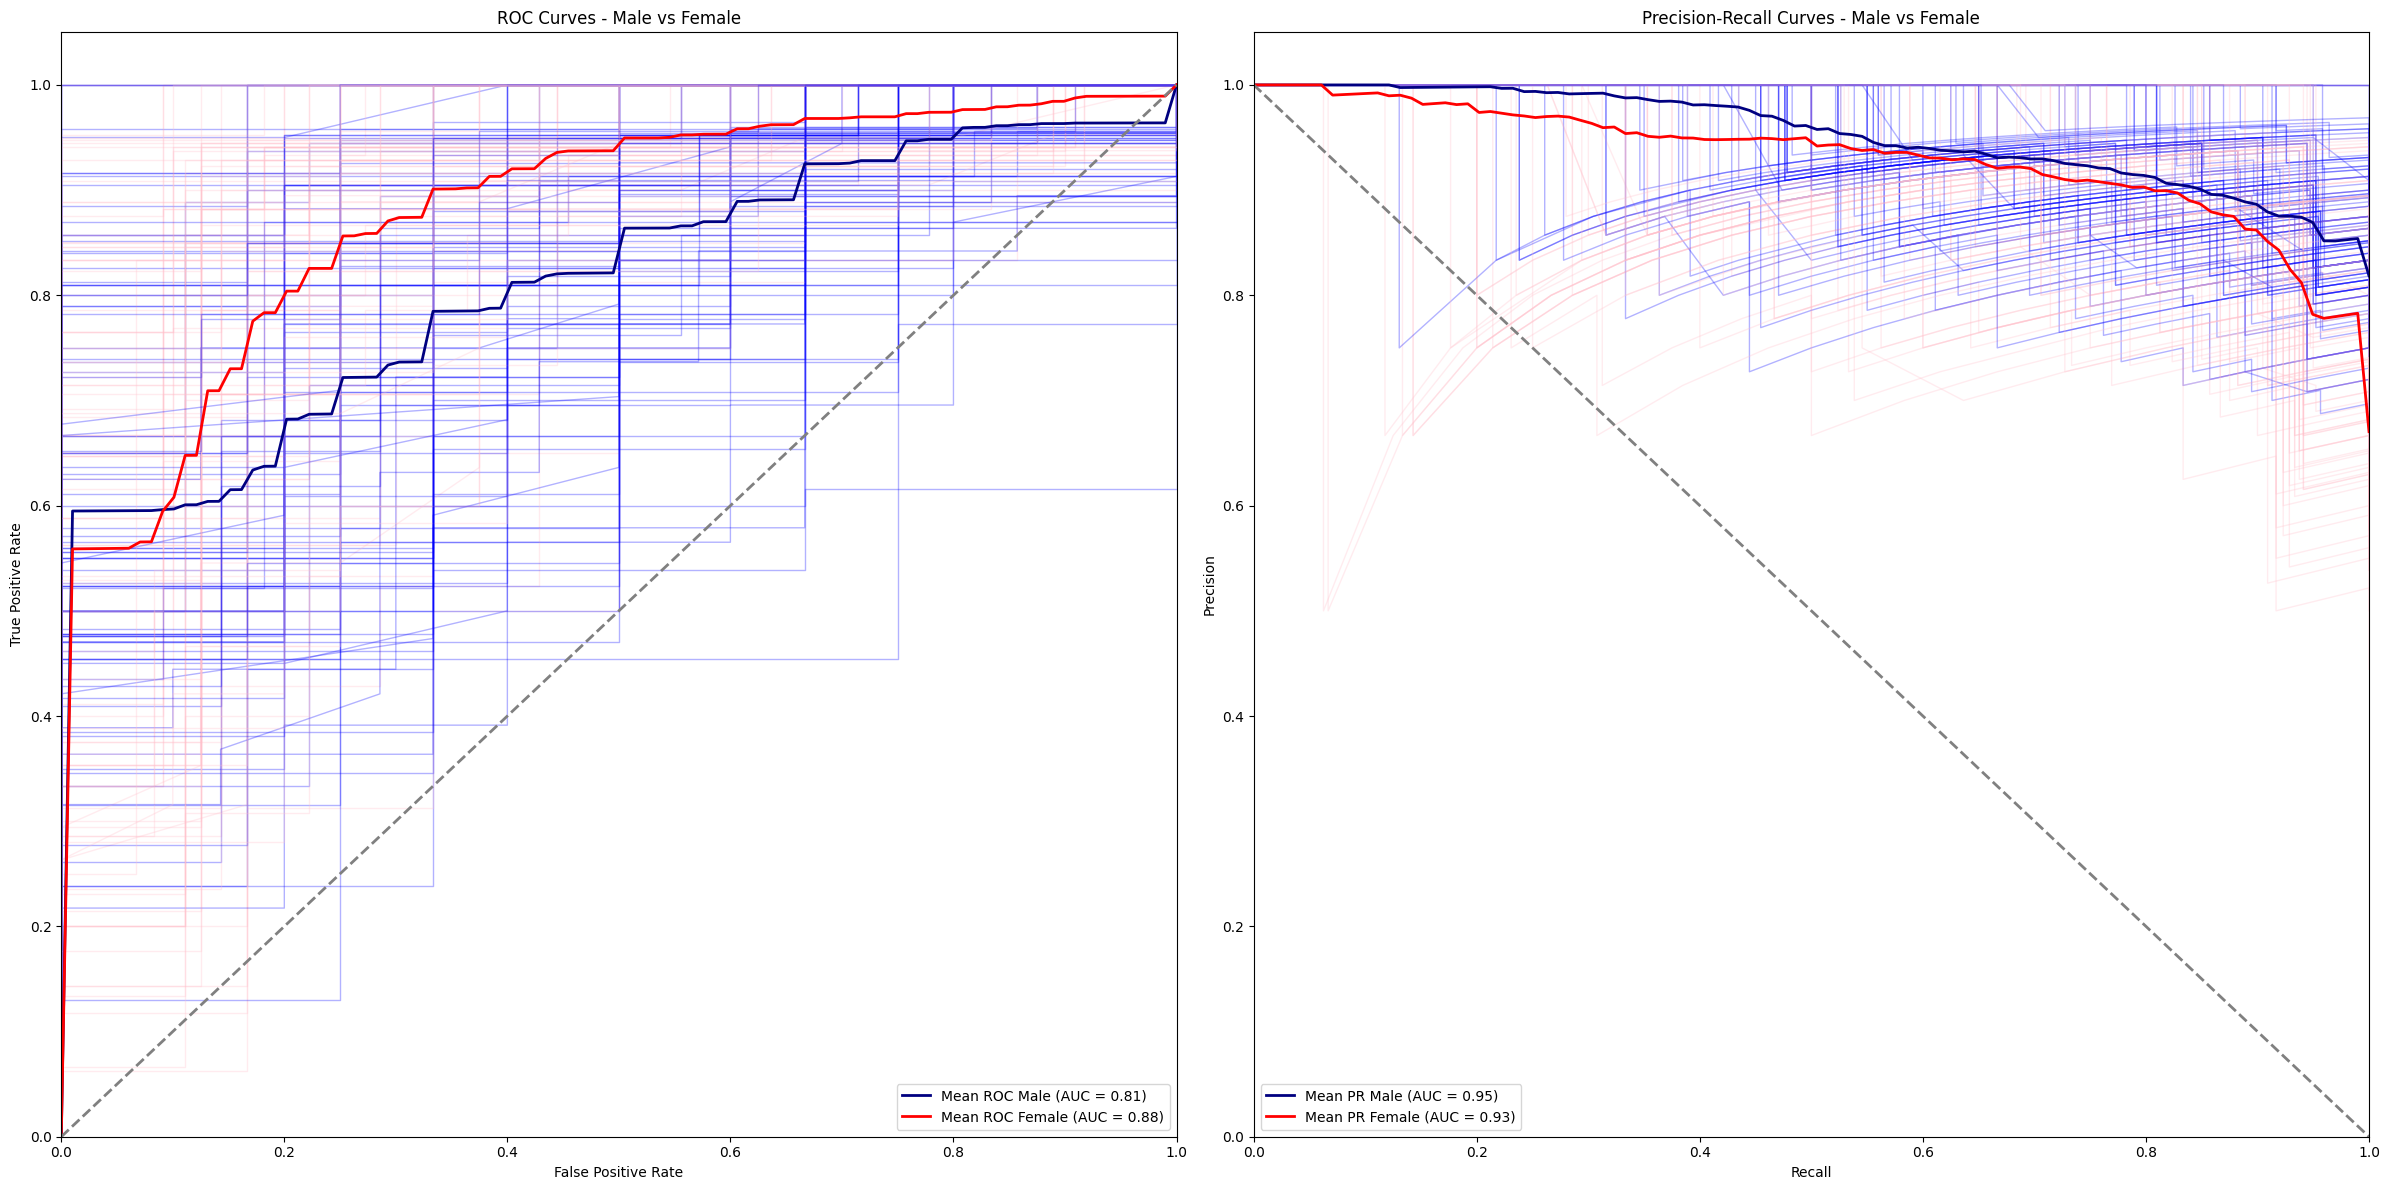

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp


plt.figure(figsize=(24, 12))

# Lists to store the curves for each random state and gender
tprs_male = []
tprs_female = []
precisions_male = []
precisions_female = []
mean_fpr = np.linspace(0, 1, 100)

for random_state in tqdm(seed_list):
    X_train, X_val, X_train_val, X_test, y_train, y_val, y_train_val, y_test = create_train_validation_test_split(speech, ('Info','class'), random_state=random_state)
    
    # Train a single Random Forest model
    rf = RandomForestClassifier(n_estimators=1000, random_state=random_state, n_jobs=-1)
    rf.fit(X_train_val[top_features], y_train_val)
    
    # Split the test data by gender
    X_test_male = X_test[X_test[('Info','gender')] == 1]
    X_test_female = X_test[X_test[('Info','gender')] == 0]
    y_test_male = y_test[X_test[('Info','gender')] == 1]
    y_test_female = y_test[X_test[('Info','gender')] == 0]
    
    # Male predictions
    y_pred_proba_male = rf.predict_proba(X_test_male[top_features])
    fpr_male, tpr_male, _ = roc_curve(y_test_male, y_pred_proba_male[:, 1])
    tprs_male.append(interp(mean_fpr, fpr_male, tpr_male))
    tprs_male[-1][0] = 0.0
    precision_male, recall_male, _ = precision_recall_curve(y_test_male, y_pred_proba_male[:, 1])
    precisions_male.append(interp(mean_fpr, recall_male[::-1], precision_male[::-1])[::-1])
    
    # Female predictions
    y_pred_proba_female = rf.predict_proba(X_test_female[top_features])
    fpr_female, tpr_female, _ = roc_curve(y_test_female, y_pred_proba_female[:, 1])
    tprs_female.append(interp(mean_fpr, fpr_female, tpr_female))
    tprs_female[-1][0] = 0.0
    precision_female, recall_female, _ = precision_recall_curve(y_test_female, y_pred_proba_female[:, 1])
    precisions_female.append(interp(mean_fpr, recall_female[::-1], precision_female[::-1])[::-1])
    
    # Plot individual curves
    plt.subplot(121)
    plt.plot(fpr_male, tpr_male, color='blue', lw=1, alpha=0.3)
    plt.plot(fpr_female, tpr_female, color='pink', lw=1, alpha=0.3)
    
    plt.subplot(122)
    plt.plot(recall_male, precision_male, color='blue', lw=1, alpha=0.3)
    plt.plot(recall_female, precision_female, color='pink', lw=1, alpha=0.3)

# Calculate and plot mean curves
mean_tpr_male = np.mean(tprs_male, axis=0)
mean_tpr_female = np.mean(tprs_female, axis=0)
mean_tpr_male[-1] = mean_tpr_female[-1] = 1.0
mean_auc_male = auc(mean_fpr, mean_tpr_male)
mean_auc_female = auc(mean_fpr, mean_tpr_female)

mean_precision_male = np.mean(precisions_male, axis=0)
mean_precision_female = np.mean(precisions_female, axis=0)
mean_auc_pr_male = auc(mean_fpr, mean_precision_male)
mean_auc_pr_female = auc(mean_fpr, mean_precision_female)

plt.subplot(121)
plt.plot(mean_fpr, mean_tpr_male, color='navy', lw=2, label=f'Mean ROC Male (AUC = {mean_auc_male:.2f})')
plt.plot(mean_fpr, mean_tpr_female, color='red', lw=2, label=f'Mean ROC Female (AUC = {mean_auc_female:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Male vs Female')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(mean_fpr, mean_precision_male[::-1], color='navy', lw=2, label=f'Mean PR Male (AUC = {mean_auc_pr_male:.2f})')
plt.plot(mean_fpr, mean_precision_female[::-1], color='red', lw=2, label=f'Mean PR Female (AUC = {mean_auc_pr_female:.2f})')
plt.plot([0, 1], [1, 0], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Male vs Female')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()